In [1]:
! pip install -q lalsuite==7.11 bilby==2.0.1 gwpy==3.0.4 matplotlib==3.5.3 dynesty==2.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all th

In [2]:
# Generating posterior data set and finding parameters probability density
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_neutron_star_parameters, generate_all_bns_parameters

from gwpy.timeseries import TimeSeries

In [3]:
from gwosc.datasets import event_gps
time_of_event = event_gps('GW170817')
print(time_of_event)

1187008882.4


In [4]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
V1 = bilby.gw.detector.get_empty_interferometer("V1")

In [5]:
# Defining times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

V1_analysis_data = TimeSeries.fetch_open_data(
    "V1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

In [7]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
V1.set_strain_data_from_gwpy_timeseries(V1_analysis_data)

In [8]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

V1_psd_data = TimeSeries.fetch_open_data(
    "V1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

In [9]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
V1_psd = V1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

In [10]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
V1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=V1_psd.frequencies.value, psd_array=V1_psd.value)

12:39 bilby INFO    : Generating frequency domain strain from given time domain strain.
12:39 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


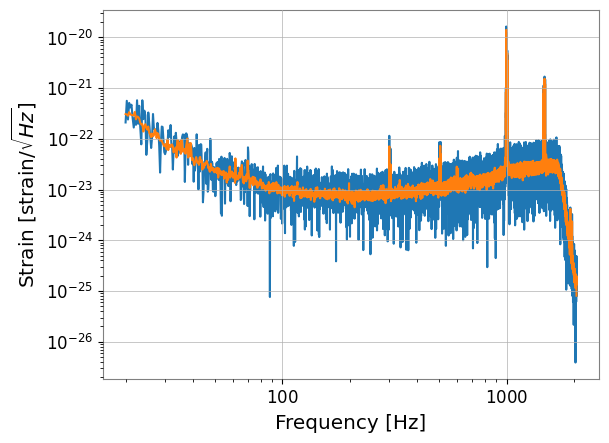

In [11]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [12]:
H1.maximum_frequency = 1024
V1.maximum_frequency = 1024

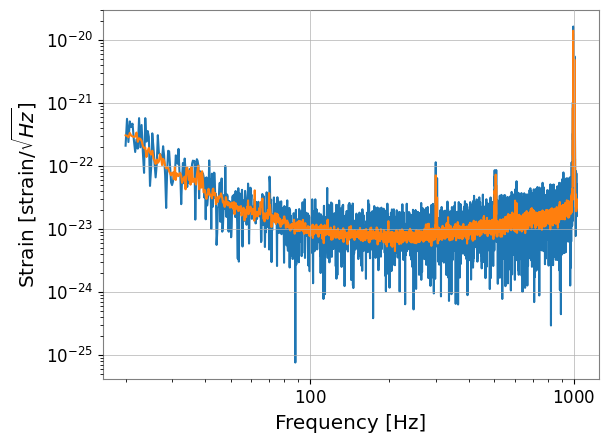

In [13]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [14]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=1.1,maximum=1.2)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.4, maximum=0.7)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-1, maximum=time_of_event+1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -23.3814
prior['ra'] =  13.1634
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=40, maximum=200, unit='Mpc', latex_label='$d_L$')

In [15]:
# Data created above put into list of interferometers
interferometers = [H1, V1]

# Specifying waveform approximant
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2_NRTidal', reference_frequency=100., catch_waveform_errors=True)

# Creating a waveform_generator object.
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters)

# Creating likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

12:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
12:40 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
12:40 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW170817",
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    nlive=250, dlogz=1.,  # <- Arguments are used to make things fast
    clean=True,
)

12:42 bilby INFO    : Running for label 'GW170817', output will be saved to 'short'
12:42 bilby INFO    : Using lal version 7.2.4
12:42 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
12:42 bilby INFO    : Using lalsimulation version 4.0.2
12:42 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
12:42 bilby INFO    : Analysis priors:
12:42 bilby INFO    : chirp_mass=Uniform(minimum=1.1, maximum=1.2, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
12:42 bilby INFO    : mass_ratio=Uniform(mini

1it [00:00, ?it/s]

12:52 bilby INFO    : Written checkpoint file short/GW170817_resume.pickle
13:05 bilby INFO    : Written checkpoint file short/GW170817_resume.pickle
13:16 bilby INFO    : Written checkpoint file short/GW170817_resume.pickle
13:26 bilby INFO    : Written checkpoint file short/GW170817_resume.pickle
13:37 bilby INFO    : Written checkpoint file short/GW170817_resume.pickle
13:44 bilby INFO    : Written checkpoint file short/GW170817_resume.pickle
13:44 bilby INFO    : Rejection sampling nested samples to obtain 258 posterior samples
13:44 bilby INFO    : Sampling time: 1:01:27.793277


13:44 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/258 [00:00<?, ?it/s]

13:44 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/258 [00:00<?, ?it/s]

13:45 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/258 [00:00<?, ?it/s]

13:45 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/258 [00:00<?, ?it/s]

13:45 bilby INFO    : Summary of results:
nsamples: 258
ln_noise_evidence: -9306.880
ln_evidence: -9266.780 +/-  0.336
ln_bayes_factor: 40.100 +/-  0.336



In [17]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,lambda_tilde,delta_lambda_tilde
0,1.196851,0.532554,-5.163237e-05,5.682410,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009006,39.772235,1.885434,1.004096,1.186169,2.889530,0.0,-0.0
1,1.196389,0.583011,9.658571e-05,4.914964,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009453,41.742262,1.795879,1.047018,1.185186,2.842897,0.0,-0.0
2,1.197845,0.612383,-2.329784e-04,1.687805,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009266,40.920614,1.752567,1.073243,1.186848,2.825810,0.0,-0.0
3,1.197629,0.607911,-3.009564e-05,4.963117,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009053,39.981396,1.759367,1.069539,1.186884,2.828906,0.0,-0.0
4,1.198300,0.667018,9.279386e-05,5.638847,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009220,40.714858,1.676817,1.118467,1.187354,2.795284,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,1.198050,0.699669,1.108055e-04,0.308387,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009652,42.620742,1.634709,1.143756,1.186597,2.778465,0.0,-0.0
254,1.197972,0.696052,6.031766e-05,0.573926,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.008997,39.732473,1.640060,1.141567,1.187290,2.781626,0.0,-0.0
255,1.198069,0.697891,-2.094775e-05,3.700273,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.010551,46.580607,1.635433,1.141355,1.185560,2.776788,0.0,-0.0
256,1.197975,0.697257,5.809211e-05,0.427610,1.187009e+09,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.009010,39.789534,1.638575,1.142508,1.187278,2.781083,0.0,-0.0


In [18]:
result_short.posterior["chirp_mass"]

0      1.196851
1      1.196389
2      1.197845
3      1.197629
4      1.198300
         ...   
253    1.198050
254    1.197972
255    1.198069
256    1.197975
257    1.198013
Name: chirp_mass, Length: 258, dtype: float64

In [19]:
Mc = result_short.posterior["chirp_mass"].values

In [20]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 1.1975861678314073 with a 90% C.I = 1.1971392299354509 -> 1.1982300203474994


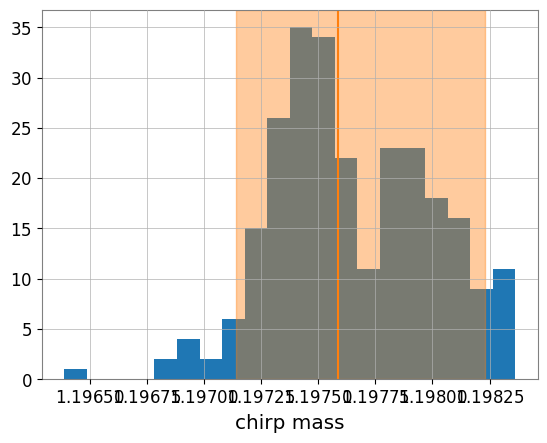

In [21]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

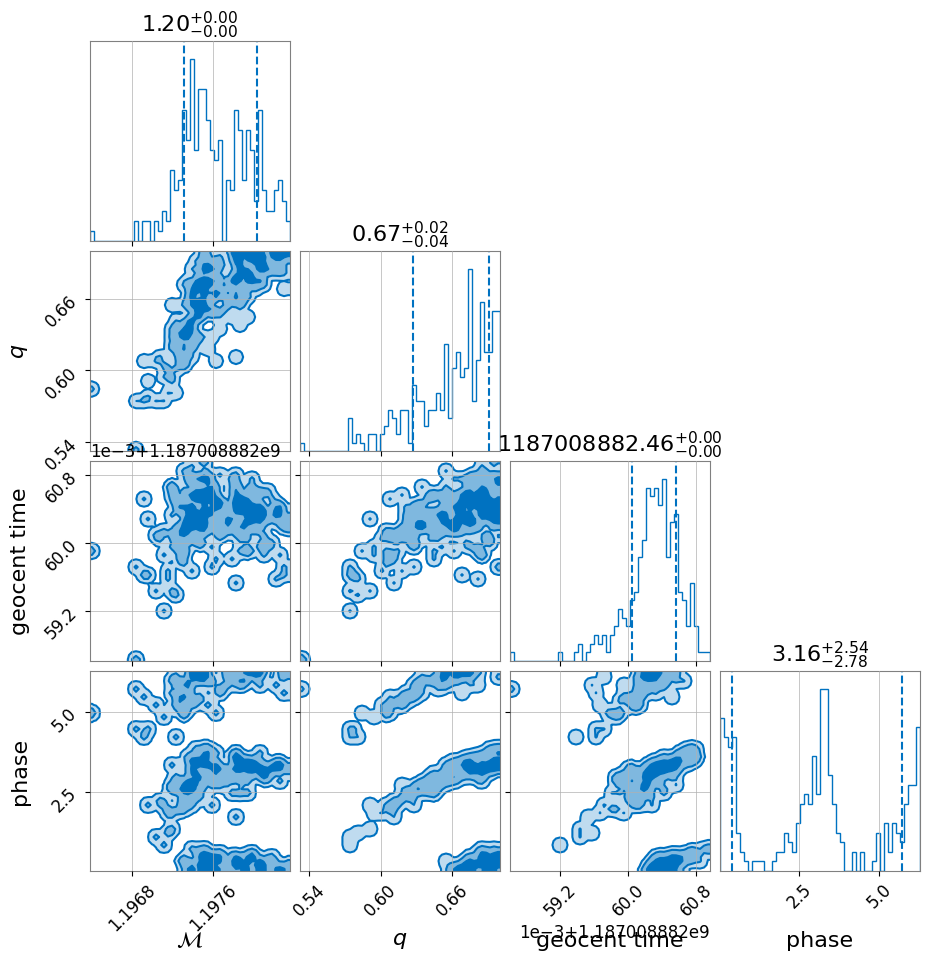

In [22]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

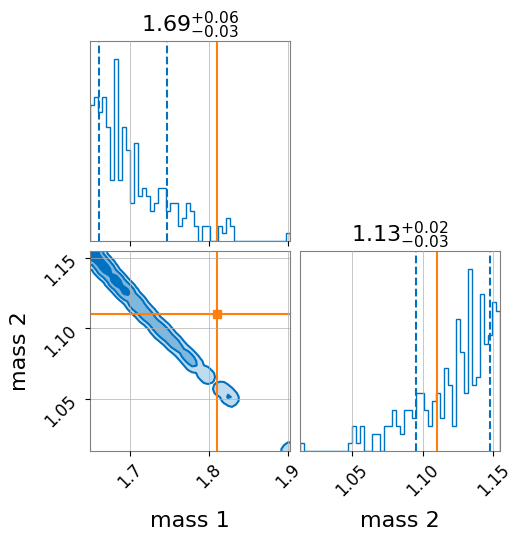

In [23]:
parameters = dict(mass_1=1.81, mass_2=1.11)
result_short.plot_corner(parameters)

In [24]:
result_short.priors

{'chirp_mass': Uniform(minimum=1.1, maximum=1.2, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.4, maximum=0.7, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1187008881.4, maximum=1187008883.4, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-23.3814, name=None, latex

In [25]:
result_short.sampler_kwargs["nlive"]

250

In [26]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 40.100333491943054 +/- 0.3359105384963205


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner

In [28]:
# importing data for GW170817

label = 'GW170817'
! wget https://dcc.ligo.org/LIGO-P1800370/public/{label}_GWTC-1.hdf5

--2024-03-13 13:50:10--  https://dcc.ligo.org/LIGO-P1800370/public/GW170817_GWTC-1.hdf5
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5 [following]
--2024-03-13 13:50:12--  https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5
Reusing existing connection to dcc.ligo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2520704 (2.4M)
Saving to: ‘GW170817_GWTC-1.hdf5’

GW170817_GWTC-1.hdf 100%[===================>]   2.40M  2.04MB/s    in 1.2s    

2024-03-13 13:50:13 (2.04 MB/s) - ‘GW170817_GWTC-1.hdf5’ saved [2520704/2520704]



In [29]:
posterior_file = './'+label+'_GWTC-1.hdf5'
posterior = h5py.File(posterior_file, 'r')

In [30]:
print('This file contains the following datasets: ',posterior.keys())

This file contains the following datasets:  <KeysViewHDF5 ['IMRPhenomPv2NRT_highSpin_posterior', 'IMRPhenomPv2NRT_highSpin_prior', 'IMRPhenomPv2NRT_lowSpin_posterior', 'IMRPhenomPv2NRT_lowSpin_prior']>


In [31]:
# list of parameters in data set

print(posterior['IMRPhenomPv2NRT_highSpin_posterior'].dtype.names)

('costheta_jn', 'luminosity_distance_Mpc', 'right_ascension', 'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun', 'lambda1', 'lambda2', 'spin1', 'spin2', 'costilt1', 'costilt2')


In [32]:
samples=pd.DataFrame.from_records(np.array(posterior['IMRPhenomPv2NRT_highSpin_posterior']))

In [33]:
samples

,costheta_jn,luminosity_distance_Mpc,right_ascension,declination,m1_detector_frame_Msun,m2_detector_frame_Msun,lambda1,lambda2,spin1,spin2,costilt1,costilt2
0,-0.994916,45.252574,3.44616,-0.408084,1.822412,1.054311,445.419935,799.248200,0.608468,0.305334,0.066403,0.175660
1,-0.986352,45.872286,3.44616,-0.408084,1.691038,1.128312,255.135494,251.741954,0.533260,0.102076,-0.047374,0.939450
2,-0.805300,37.419041,3.44616,-0.408084,1.712651,1.115415,244.847341,1240.723296,0.215738,0.099924,0.136563,0.429723
3,-0.994375,47.550072,3.44616,-0.408084,1.686980,1.130922,243.045010,736.271684,0.594491,0.078411,0.088646,-0.385641
4,-0.972559,46.396693,3.44616,-0.408084,1.433279,1.320945,426.830092,522.957181,0.210956,0.518581,0.891070,-0.349811
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,-0.572411,27.509286,3.44616,-0.408084,1.653054,1.152224,50.542338,1735.777536,0.422435,0.435869,-0.035111,0.145682
4037,-0.967601,44.951726,3.44616,-0.408084,1.676843,1.137493,878.454223,937.486106,0.272463,0.587713,0.607517,-0.269435
4038,-0.821259,38.931113,3.44616,-0.408084,1.648230,1.155479,63.444686,399.916795,0.296918,0.356141,-0.505885,0.852718
4039,-0.726254,36.055606,3.44616,-0.408084,1.530936,1.239088,1104.912120,219.981332,0.332348,0.463105,-0.177109,0.232242


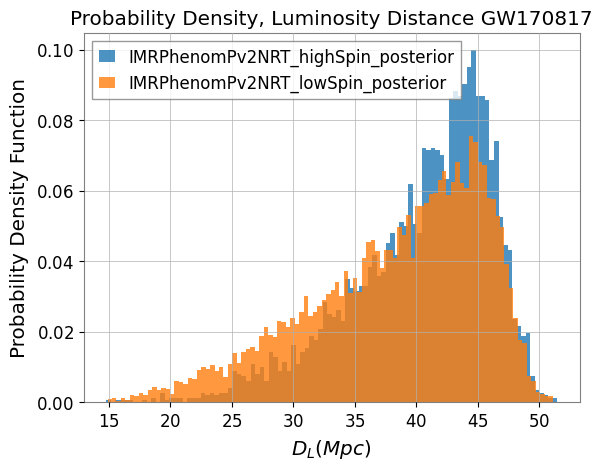

In [34]:
plt.hist(posterior['IMRPhenomPv2NRT_highSpin_posterior']['luminosity_distance_Mpc'], bins = 100, label='IMRPhenomPv2NRT_highSpin_posterior', alpha=0.8, density=True)
plt.hist(posterior['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc'], bins = 100, label='IMRPhenomPv2NRT_lowSpin_posterior', alpha=0.8, density=True)
plt.xlabel(r'$D_L (Mpc)$')
plt.ylabel('Probability Density Function')
plt.title('Probability Density, Luminosity Distance GW170817')
plt.legend()
plt.show()

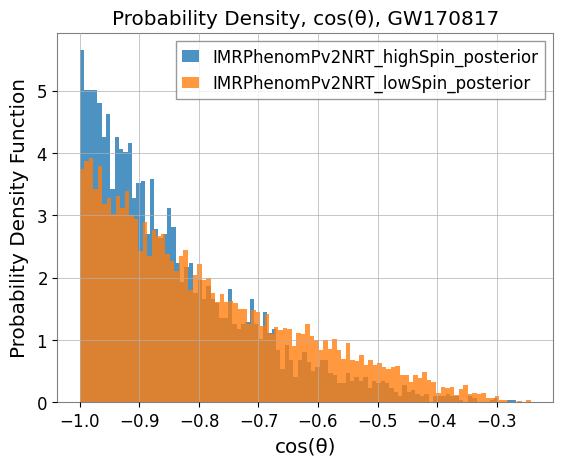

In [35]:
plt.hist(posterior['IMRPhenomPv2NRT_highSpin_posterior']['costheta_jn'], bins = 100, label='IMRPhenomPv2NRT_highSpin_posterior', alpha=0.8, density=True)
plt.hist(posterior['IMRPhenomPv2NRT_lowSpin_posterior']['costheta_jn'], bins = 100, label='IMRPhenomPv2NRT_lowSpin_posterior', alpha=0.8, density=True)
plt.xlabel('cos(θ)')
plt.ylabel('Probability Density Function')
plt.title('Probability Density, cos(θ), GW170817')
plt.legend()
plt.show()

In [36]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

In [37]:
z = np.array([z_at_value(Planck15.luminosity_distance, dist * u.Mpc) for dist in samples['luminosity_distance_Mpc']])

In [38]:
samples['m1_detector_frame_Msun']=samples['m1_detector_frame_Msun']/(1.0+z)
samples['m2_detector_frame_Msun']=samples['m2_detector_frame_Msun']/(1.0+z)
samples['redshift']=z

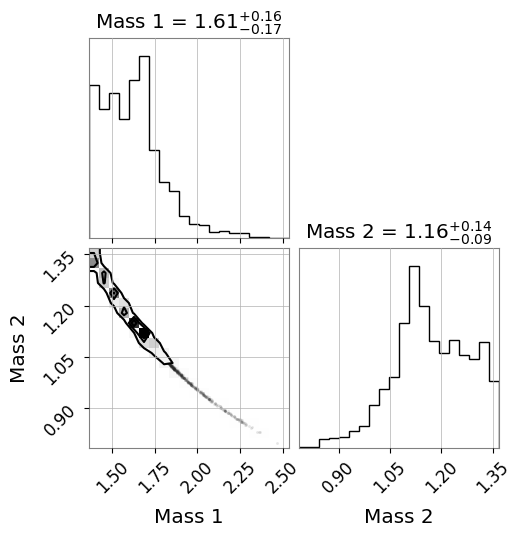

In [39]:
corner.corner(samples[['m1_detector_frame_Msun','m2_detector_frame_Msun']].values, labels=['Mass 1', 'Mass 2'], show_titles=True);

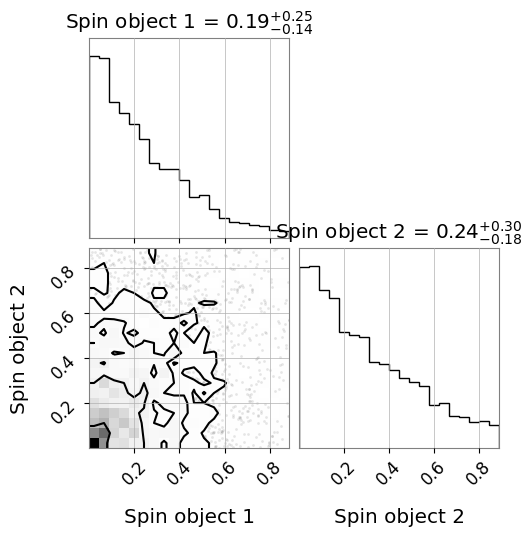

In [40]:
corner.corner(samples[['spin1','spin2']].values,labels=['Spin object 1','Spin object 2'],show_titles=True);

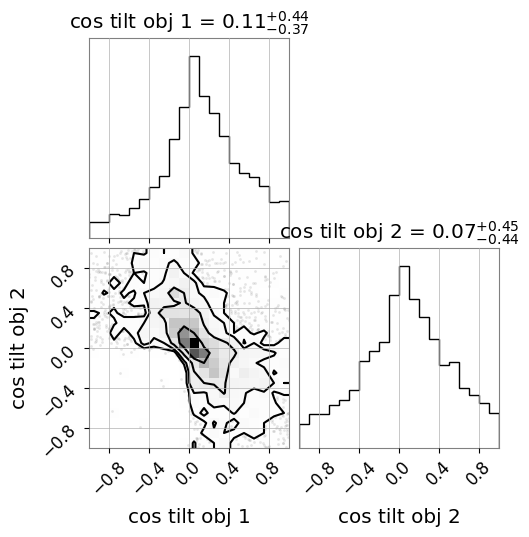

In [41]:
corner.corner(samples[['costilt1','costilt2']].values,labels=['cos tilt obj 1','cos tilt obj 2'],title='Title', show_titles=True);

In [42]:
import bilby
# calculate the detector frame chirp mass
mchirp = ((samples['m1_detector_frame_Msun'] * samples['m2_detector_frame_Msun'])**(3./5))/\
         (samples['m1_detector_frame_Msun'] + samples['m2_detector_frame_Msun'])**(1./5)
# initialize a SampleSummary object to describe the chirp mass posterior samples
chirp_mass_samples_summary = bilby.core.utils.SamplesSummary(samples=mchirp, average='median')
print('The median chirp mass = {} Msun'.format(chirp_mass_samples_summary.median))
print('The 90% confidence interval for the chirp mass is {} - {} Msun'.format(chirp_mass_samples_summary.lower_absolute_credible_interval,
                                                                        chirp_mass_samples_summary.upper_absolute_credible_interval))


The median chirp mass = 1.1865408065440015 Msun
The 90% confidence interval for the chirp mass is 1.1850201754370686 - 1.1898504155522647 Msun
